In [1]:
import numpy as np
import pandas
from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [2]:
# state to two-letter abbreviation mapping

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}
us_state_abbrev_lower = { k: us_state_abbrev[k].lower() for k in us_state_abbrev.keys() }

In [3]:
# read CMU data

cmu_columns = (0, 1, 2, 3, 4, 54, 55, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 81, 93)
cmu_column_names = (
    # date and demographics
    'date',
    'state',
    'gender',
    'age_bucket',
    'summed_n',
    # symptoms
    'smoothed_pct_cli_weighted',
    'smoothed_pct_ili_weighted',
    'smoothed_pct_self_fever_weighted',
    'smoothed_pct_self_cough_weighted',
    'smoothed_pct_self_shortness_of_breath_weighted',
    'smoothed_pct_self_difficulty_breathing_weighted',
    'smoothed_pct_self_tiredness_or_exhaustion_weighted',
    'smoothed_pct_self_nasal_congestion_weighted',
    'smoothed_pct_self_runny_nose_weighted',
    'smoothed_pct_self_muscle_joint_aches_weighted',
    'smoothed_pct_self_sore_throat_weighted',
    'smoothed_pct_self_persistent_pain_pressure_in_chest_weighted',
    'smoothed_pct_self_nausea_vomiting_weighted',
    'smoothed_pct_self_diarrhea_weighted',
    'smoothed_pct_self_multiple_symptoms_weighted',   
)
cmu_column_formats = (
    'U10', 'U2','U10','U10', 'f',
    'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f',   
)

cmu_data = np.loadtxt(
    fname="/Users/lsu/Downloads/cmuData.csv", 
    delimiter=",", 
    skiprows=1,
    usecols=cmu_columns,
    dtype={
        'names': cmu_column_names,
        'formats': cmu_column_formats,
    }
)

cmu_data = pandas.DataFrame(cmu_data, columns=cmu_column_names)
# aggregate by state, date
cmu_data = pysqldf("""
select
    date,
    state,
    sum(summed_n * smoothed_pct_cli_weighted) / sum(summed_n) smoothed_pct_cli_weighted,
    sum(summed_n * smoothed_pct_ili_weighted) / sum(summed_n) smoothed_pct_ili_weighted,
    sum(summed_n * smoothed_pct_self_fever_weighted) / sum(summed_n) smoothed_pct_self_fever_weighted,
    sum(summed_n * smoothed_pct_self_cough_weighted) / sum(summed_n) smoothed_pct_self_cough_weighted,
    sum(summed_n * smoothed_pct_self_shortness_of_breath_weighted) / sum(summed_n) smoothed_pct_self_shortness_of_breath_weighted,
    sum(summed_n * smoothed_pct_self_difficulty_breathing_weighted) / sum(summed_n) smoothed_pct_self_difficulty_breathing_weighted,
    sum(summed_n * smoothed_pct_self_tiredness_or_exhaustion_weighted) / sum(summed_n) smoothed_pct_self_tiredness_or_exhaustion_weighted,
    sum(summed_n * smoothed_pct_self_nasal_congestion_weighted) / sum(summed_n) smoothed_pct_self_nasal_congestion_weighted,
    sum(summed_n * smoothed_pct_self_runny_nose_weighted) / sum(summed_n) smoothed_pct_self_runny_nose_weighted,
    sum(summed_n * smoothed_pct_self_muscle_joint_aches_weighted) / sum(summed_n) smoothed_pct_self_muscle_joint_aches_weighted,
    sum(summed_n * smoothed_pct_self_sore_throat_weighted) / sum(summed_n) smoothed_pct_self_sore_throat_weighted,
    sum(summed_n * smoothed_pct_self_persistent_pain_pressure_in_chest_weighted) / sum(summed_n) smoothed_pct_self_persistent_pain_pressure_in_chest_weighted,
    sum(summed_n * smoothed_pct_self_nausea_vomiting_weighted) / sum(summed_n) smoothed_pct_self_nausea_vomiting_weighted,
    sum(summed_n * smoothed_pct_self_diarrhea_weighted) / sum(summed_n) smoothed_pct_self_diarrhea_weighted,
    sum(summed_n * smoothed_pct_self_multiple_symptoms_weighted) / sum(summed_n) smoothed_pct_self_multiple_symptoms_weighted    
from
    cmu_data
group by
    state,
    date
""")
cmu_data

,date,state,smoothed_pct_cli_weighted,smoothed_pct_ili_weighted,smoothed_pct_self_fever_weighted,smoothed_pct_self_cough_weighted,smoothed_pct_self_shortness_of_breath_weighted,smoothed_pct_self_difficulty_breathing_weighted,smoothed_pct_self_tiredness_or_exhaustion_weighted,smoothed_pct_self_nasal_congestion_weighted,smoothed_pct_self_runny_nose_weighted,smoothed_pct_self_muscle_joint_aches_weighted,smoothed_pct_self_sore_throat_weighted,smoothed_pct_self_persistent_pain_pressure_in_chest_weighted,smoothed_pct_self_nausea_vomiting_weighted,smoothed_pct_self_diarrhea_weighted,smoothed_pct_self_multiple_symptoms_weighted
0,2020-04-12,ak,0.924492,1.033970,1.223670,15.621587,4.648244,2.221548,15.080866,16.142131,17.960842,12.334458,8.093897,2.980421,3.184342,6.925321,2.007392
1,2020-04-13,ak,0.714637,0.837073,1.082856,15.716196,4.509300,2.343243,15.444852,15.945381,17.852757,12.282205,8.165403,2.882388,3.512986,7.078623,2.048637
2,2020-04-14,ak,0.636186,0.746453,1.042392,15.850805,4.636723,2.546868,15.347976,15.046316,17.411818,12.411797,8.227200,2.931977,3.415793,7.665086,1.898561
3,2020-04-15,ak,0.614031,0.647247,1.013692,15.618680,4.376966,2.458152,14.882340,14.578623,16.854770,12.136618,7.935197,2.744155,3.238339,7.546989,1.484081
4,2020-04-16,ak,0.586744,0.734023,0.945736,15.303189,4.036254,2.200012,14.903203,14.086725,16.717885,12.257689,7.489968,2.546724,2.952347,7.149550,1.577806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8165,2020-09-12,wy,0.560018,0.560018,0.741239,11.398363,4.629123,3.793869,14.862366,11.918800,12.598999,13.851975,6.192486,1.607000,2.354441,6.089271,1.168108
8166,2020-09-13,wy,0.525296,0.525296,0.697688,11.568170,4.907196,3.872609,14.602297,11.092391,12.676422,13.245338,6.117486,1.679287,2.598346,6.003052,1.158585
8167,2020-09-14,wy,0.881329,0.881329,1.049404,11.864266,5.269843,4.063718,14.791969,12.882670,12.695917,13.566410,6.380437,1.614517,2.796098,6.195610,1.454078
8168,2020-09-15,wy,0.709444,0.709444,0.876834,10.680328,4.848462,3.472864,14.655529,13.612076,13.239250,13.129453,6.874728,1.439733,2.762325,6.081717,1.446053


In [4]:
# read policy data

policy_columns = (0, 3, 4, 5, 6)
policy_column_names = (
    'state_id',
    'policy_level',
    'date',
    'policy_type',
    'start_stop',
)
policy_column_formats = (
    'U4',
    'U20',
    'U10',
    'U100',
    'U10',
)

raw_policy_data = np.genfromtxt(
    fname="/Users/lsu/Downloads/state_policy_updates_20201019_1216_compact.csv", 
    delimiter=",", 
    skip_header=1,
    usecols=policy_columns,
    dtype={
        'names': policy_column_names,
        'formats': policy_column_formats,
    },
    converters={
        0: lambda x: x.decode("utf-8").lower(),
        4: lambda x: datetime.strftime(datetime.strptime(x.decode("utf-8"), "%m/%d/%y"), "%Y-%m-%d")
    }
)

raw_policy_data = pandas.DataFrame(raw_policy_data, columns=policy_column_names)

raw_policy_data = pysqldf("""
select
    date,
    state_id,
    policy_type,
    start_stop
from
    raw_policy_data
where
    policy_level = 'state' and
    policy_type in (
        'Shelter in Place',
        'Food and Drink',
        'Non-Essential Businesses',
        'Mandate Face Mask Use By All Individuals In Public Spaces',
        'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
    )
order by
    state_id,
    policy_type,
    date
""")

policy_start = pysqldf("select * from raw_policy_data where start_stop = 'start'")
policy_stop = pysqldf("select * from raw_policy_data where start_stop = 'stop'")

policy_data = pysqldf("""
select
    a.state_id state_id,
    a.policy_type policy_type,
    a.date start_date,
    b.date stop_date,
    a.start_stop,
    b.start_stop
from
    policy_start a
left outer join
    policy_stop b
on
    a.state_id = b.state_id and
    a.policy_type = b.policy_type
order by
    a.state_id,
    a.policy_type
""")

policy_data

,state_id,policy_type,start_date,stop_date,start_stop,start_stop
0,ak,Food and Drink,2020-03-18,2020-04-24,start,stop
1,ak,Mandate Face Mask Use By All Individuals In Pu...,2020-04-24,None,start,None
2,ak,Mandate Face Mask Use By All Individuals In Pu...,2020-04-24,None,start,None
3,ak,Non-Essential Businesses,2020-03-28,2020-04-24,start,stop
4,ak,Shelter in Place,2020-03-28,2020-04-24,start,stop
...,...,...,...,...,...,...
222,wv,Non-Essential Businesses,2020-03-24,2020-05-04,start,stop
223,wv,Shelter in Place,2020-03-24,2020-05-04,start,stop
224,wy,Food and Drink,2020-03-19,2020-05-15,start,stop
225,wy,Mandate Face Mask Use By All Individuals In Pu...,2020-05-01,None,start,None


In [5]:
# load 2019 population data

population2019_column_names = (
    'state',
    'population2019'
)
population2019_column_formats = (
    'U30',
    'd'
)
population2019_data = np.genfromtxt(
    fname="/Users/lsu/Downloads/state_population_2019.csv", 
    delimiter=",", 
    skip_header=0,
    dtype={
        'names': population2019_column_names,
        'formats': population2019_column_formats,       
    },
    converters={
        0: lambda x: us_state_abbrev_lower.get(x.decode("utf-8"), None)
    } 
)
    
population2019_data = pandas.DataFrame(population2019_data, columns=population2019_column_names)
population2019_data = pysqldf("""
select
    *
from
    population2019_data
order by
    state
""")

population2019_data

,state,population2019
0,None,705749.0
1,ak,731545.0
2,al,4903185.0
3,ar,3017825.0
4,az,7278717.0
5,ca,39512223.0
6,co,5758736.0
7,ct,3565287.0
8,de,973764.0
9,fl,21477737.0


In [6]:
# load CSSE data

# = shell script to merge per-day CSV files

# #!/bin/bash

# echo -n Date,
# cat `ls | head -n 1` | head -n 1
# for filename in `ls`; do
#     if [[ "$filename" =~ ([0-9][0-9])\-([0-9][0-9])\-([0-9][0-9][0-9][0-9]) ]]; then
#         date=${BASH_REMATCH[3]}-${BASH_REMATCH[1]}-${BASH_REMATCH[2]}
#         tail -n +2 $filename | sed -e "s/^/$date,/"
#     fi
# done


csse_columns = (0, 1, 6, 7, 8, 9, 12, 13, 14, 17, 18)
csse_column_names = (
    'date',
    'state',
    'confirmed',
    'death',
    'recovered',
    'active',
    'tested',
    'hospitalized',
    'mortality_rate',
    'testing_rate',
    'hospitalization_rate',
)
csse_column_formats = (
    'U10',
    'U30',
    'f',
    'f',
    'f',
    'f',
    'f',
    'f',
    'f',
    'f',
    'f',  
)

csse_raw_data = np.genfromtxt(
    fname="/Users/lsu/Downloads/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/merged.csv", 
    delimiter=",", 
    skip_header=1,
    usecols=csse_columns,
    dtype={
        'names': csse_column_names,
        'formats': csse_column_formats,       
    },
    converters={
        1: lambda x: us_state_abbrev_lower.get(x.decode("utf-8"), None)
    } 
)

csse_raw_data = pandas.DataFrame(csse_raw_data, columns=csse_column_names)
csse_raw_data = pysqldf("""
select
    *
from
    csse_raw_data
where
    state != 'None'
order by
    state,
    date
""")

csse_data = pysqldf("""
select
    d2.*,
    d2.confirmed - d1.confirmed confirmed_delta,
    d2.tested - d1.tested tested_delta
from
    csse_raw_data d1
inner join
    csse_raw_data d2
on
    julianday(d2.date) - julianday(d1.date) = 1 and 
    d1.state = d2.state
where
    confirmed_delta > 0 and
    tested_delta > 0
""")


csse_data


,date,state,confirmed,death,recovered,active,tested,hospitalized,mortality_rate,testing_rate,hospitalization_rate,confirmed_delta,tested_delta
0,2020-04-14,ak,285.0,9.0,98.0,276.0,8348.0,32.0,3.157895,1396.572754,11.228070,8.0,518.0
1,2020-04-15,ak,293.0,9.0,106.0,284.0,8664.0,34.0,3.071672,1449.437866,11.604095,8.0,316.0
2,2020-04-16,ak,300.0,9.0,110.0,291.0,8735.0,35.0,3.000000,1461.315674,11.666667,7.0,71.0
3,2020-04-17,ak,309.0,9.0,128.0,300.0,9450.0,36.0,2.912621,1580.931152,11.650485,9.0,715.0
4,2020-04-18,ak,314.0,9.0,147.0,305.0,9655.0,39.0,2.866242,1615.226440,12.420382,5.0,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11407,2020-11-22,wy,28169.0,176.0,16807.0,11186.0,159957.0,NaN,0.624800,27637.929688,NaN,759.0,759.0
11408,2020-11-23,wy,29431.0,202.0,17452.0,11777.0,161219.0,NaN,0.686351,27855.982422,NaN,1262.0,1262.0
11409,2020-11-24,wy,29959.0,202.0,17896.0,11861.0,161747.0,NaN,0.674255,27947.210938,NaN,528.0,528.0
11410,2020-11-25,wy,30761.0,215.0,20113.0,10433.0,385040.0,NaN,0.698937,66528.554688,NaN,802.0,223293.0


In [7]:
# join all data together


policy1_data = pysqldf("select * from policy_data where policy_type = 'Shelter in Place'")
policy2_data = pysqldf("select * from policy_data where policy_type = 'Food and Drink'")
policy3_data = pysqldf("select * from policy_data where policy_type = 'Non-Essential Businesses'")
policy4_data = pysqldf(
    "select * from policy_data where policy_type = 'Mandate Face Mask Use By All Individuals In Public Spaces'")
policy5_data = pysqldf(
    "select * from policy_data where policy_type = 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'")

all_data_combined = pysqldf("""
select
    csse_data.*,
    cmu_data.*,
    population2019_data.population2019,
    case when policy1.policy_type is not null then 1 else 0 end shelter_in_place_policy,
    case when policy2.policy_type is not null then 1 else 0 end food_and_drink_policy,
    case when policy3.policy_type is not null then 1 else 0 end non_essential_businesses_policy,
    case when policy4.policy_type is not null then 1 else 0 end face_mask_public_policy,
    case when policy5.policy_type is not null then 1 else 0 end face_mask_business_policy,
    case when cmu_data.state is not null then 1 else 0 end has_cmu_data
from
    csse_data
left outer join
    population2019_data
on
    csse_data.state = population2019_data.state
left outer join
    cmu_data
on
    csse_data.date = cmu_data.date and
    csse_data.state = cmu_data.state
left outer join
    policy1_data policy1
on
    csse_data.state = policy1.state_id and
    policy1.start_date <= csse_data.date and
    (policy1.stop_date >= csse_data.date or policy1.stop_date is null)
left outer join
    policy2_data policy2
on
    csse_data.state = policy2.state_id and
    policy2.start_date <= csse_data.date and
    (policy2.stop_date >= csse_data.date or policy2.stop_date is null)
left outer join
    policy3_data policy3
on
    csse_data.state = policy3.state_id and
    policy3.start_date <= csse_data.date and
    (policy3.stop_date >= csse_data.date or policy3.stop_date is null)
left outer join
    policy4_data policy4
on
    csse_data.state = policy4.state_id and
    policy4.start_date <= csse_data.date and
    (policy4.stop_date >= csse_data.date or policy4.stop_date is null)
left outer join
    policy5_data policy5
on
    csse_data.state = policy5.state_id and
    policy5.start_date <= csse_data.date and
    (policy5.stop_date >= csse_data.date or policy5.stop_date is null)
""")

all_data_combined


,date,state,confirmed,death,recovered,active,tested,hospitalized,mortality_rate,testing_rate,...,smoothed_pct_self_nausea_vomiting_weighted,smoothed_pct_self_diarrhea_weighted,smoothed_pct_self_multiple_symptoms_weighted,population2019,shelter_in_place_policy,food_and_drink_policy,non_essential_businesses_policy,face_mask_public_policy,face_mask_business_policy,has_cmu_data
0,2020-04-14,ak,285.0,9.0,98.0,276.0,8348.0,32.0,3.157895,1396.572754,...,3.415793,7.665086,1.898561,731545.0,1,1,1,0,0,1
1,2020-04-15,ak,293.0,9.0,106.0,284.0,8664.0,34.0,3.071672,1449.437866,...,3.238339,7.546989,1.484081,731545.0,1,1,1,0,0,1
2,2020-04-16,ak,300.0,9.0,110.0,291.0,8735.0,35.0,3.000000,1461.315674,...,2.952347,7.149550,1.577806,731545.0,1,1,1,0,0,1
3,2020-04-17,ak,309.0,9.0,128.0,300.0,9450.0,36.0,2.912621,1580.931152,...,2.956160,7.396441,1.516258,731545.0,1,1,1,0,0,1
4,2020-04-18,ak,314.0,9.0,147.0,305.0,9655.0,39.0,2.866242,1615.226440,...,2.916061,7.048577,1.266249,731545.0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11407,2020-11-22,wy,28169.0,176.0,16807.0,11186.0,159957.0,NaN,0.624800,27637.929688,...,NaN,NaN,NaN,578759.0,0,0,0,0,1,0
11408,2020-11-23,wy,29431.0,202.0,17452.0,11777.0,161219.0,NaN,0.686351,27855.982422,...,NaN,NaN,NaN,578759.0,0,0,0,0,1,0
11409,2020-11-24,wy,29959.0,202.0,17896.0,11861.0,161747.0,NaN,0.674255,27947.210938,...,NaN,NaN,NaN,578759.0,0,0,0,0,1,0
11410,2020-11-25,wy,30761.0,215.0,20113.0,10433.0,385040.0,NaN,0.698937,66528.554688,...,NaN,NaN,NaN,578759.0,0,0,0,0,1,0


In [8]:
# generate training and demo data
# feature from day 1
# use day 14 confirmed_delta_per_capita as label

labeled_data = pysqldf("""
select
    present.date,
    future.confirmed_delta / present.population2019 future_confirmed_delta_per_capita,
    present.state,
    present.smoothed_pct_cli_weighted,
    present.smoothed_pct_ili_weighted,
    present.smoothed_pct_self_fever_weighted,
    present.smoothed_pct_self_cough_weighted,
    present.smoothed_pct_self_shortness_of_breath_weighted,
    present.smoothed_pct_self_difficulty_breathing_weighted,
    present.smoothed_pct_self_tiredness_or_exhaustion_weighted,
    present.smoothed_pct_self_nasal_congestion_weighted,
    present.smoothed_pct_self_runny_nose_weighted,
    present.smoothed_pct_self_muscle_joint_aches_weighted,
    present.smoothed_pct_self_sore_throat_weighted,
    present.smoothed_pct_self_persistent_pain_pressure_in_chest_weighted,
    present.smoothed_pct_self_nausea_vomiting_weighted,
    present.smoothed_pct_self_diarrhea_weighted,
    present.smoothed_pct_self_multiple_symptoms_weighted,
    present.shelter_in_place_policy,
    present.food_and_drink_policy,
    present.non_essential_businesses_policy,
    present.face_mask_public_policy,
    present.face_mask_business_policy,
    present.active / present.population2019 active_per_capita,
    present.confirmed / present.population2019 confirmed_per_capita,
    present.confirmed_delta / present.population2019 confirmed_delta_per_capita   
from
    all_data_combined present
inner join
    all_data_combined future
on
    julianday(future.date) - julianday(present.date) = 14 and
    present.state = future.state
where
    future_confirmed_delta_per_capita is not null and
    present.has_cmu_data
order by
    present.date,
    present.state
""")


labeled_data



,date,future_confirmed_delta_per_capita,state,smoothed_pct_cli_weighted,smoothed_pct_ili_weighted,smoothed_pct_self_fever_weighted,smoothed_pct_self_cough_weighted,smoothed_pct_self_shortness_of_breath_weighted,smoothed_pct_self_difficulty_breathing_weighted,smoothed_pct_self_tiredness_or_exhaustion_weighted,...,smoothed_pct_self_diarrhea_weighted,smoothed_pct_self_multiple_symptoms_weighted,shelter_in_place_policy,food_and_drink_policy,non_essential_businesses_policy,face_mask_public_policy,face_mask_business_policy,active_per_capita,confirmed_per_capita,confirmed_delta_per_capita
0,2020-04-13,0.000030,al,1.061175,1.095937,1.329804,18.806119,5.852417,2.763908,14.412259,...,7.148619,1.862451,1,1,1,0,0,0.000741,0.000789,0.000041
1,2020-04-13,0.000023,ar,1.107573,1.073379,1.287236,19.750751,5.952442,2.957267,16.249394,...,7.099813,1.748727,0,1,1,0,0,0.000458,0.000467,0.000043
2,2020-04-13,0.000026,az,1.065547,1.081123,1.354223,15.544654,5.663844,2.668707,15.266326,...,6.549384,1.574480,1,1,1,0,0,0.000492,0.000509,0.000022
3,2020-04-13,0.000036,ca,0.664891,0.663204,0.876870,13.425639,4.068206,2.041942,11.994709,...,5.509776,1.253120,1,1,1,0,0,0.000588,0.000606,0.000029
4,2020-04-13,0.000076,co,1.441438,1.459337,1.727728,16.251716,5.999360,3.197653,16.032279,...,6.904712,1.937172,1,1,1,0,0,0.001282,0.001336,0.000067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6394,2020-09-02,0.000242,wi,0.534142,0.600385,0.763836,8.487989,3.750558,2.387601,12.874050,...,4.974459,1.205205,0,0,0,1,1,0.001262,0.013247,0.000094
6395,2020-09-02,0.000121,wv,0.678395,0.691561,0.901347,9.613960,5.152058,3.073501,13.811087,...,5.845513,1.247386,0,0,0,1,1,0.001205,0.005947,0.000081
6396,2020-09-02,0.000218,wy,0.646955,0.764724,0.943722,9.336400,5.207477,3.416411,13.847044,...,6.992238,1.007030,0,0,0,0,1,0.001073,0.006758,0.000064
6397,2020-09-03,0.000260,ne,0.871715,0.859748,1.049642,10.189682,4.143652,2.520282,15.388921,...,6.160873,1.698909,0,0,0,0,1,0.004445,0.018336,0.000245


In [9]:
# split train and test by date

dates = pysqldf("select distinct date from labeled_data order by date").to_numpy()[:, 0]

split_by_date = dates[round(np.size(dates) * .8)]

train_data = pysqldf("select * from labeled_data where date < '{split_by_date}'".format(split_by_date = split_by_date))
test_data = pysqldf("select * from labeled_data where date >= '{split_by_date}'".format(split_by_date = split_by_date))

test_data

# init state feature encoder
state_feature_encoder = OneHotEncoder()
state_feature_encoder.fit(labeled_data.to_numpy()[:, [2]])

def gen_xy(data):
    data_np = data.to_numpy()
    # remove date
    data_np = np.delete(data_np, 0, 1)
    # get label
    y = data_np[:, 0]
    # remove label
    data_np = np.delete(data_np, 0, 1)
    # encode state in one-hot
    state_feature = data_np[:, [0]]
    state_feature = state_feature_encoder.transform(state_feature).toarray()
    # remove state feature
    other_features = np.delete(data_np, 0, 1)
    # concatenate state feature and other features
    x = np.concatenate((state_feature, other_features), 1)
    # return
    return x, y

# train model
x_train, y_train = gen_xy(train_data)
x_test, y_test = gen_xy(test_data)

est = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3, 
    random_state=0, 
    loss='ls'
).fit(x_train, y_train)

# eval model

mean_squared_error(y_test, est.predict(x_test))

5.1930416092161906e-09

In [14]:
# generate state level policy exploded evaluation data

state = 'ca'

state_test_data = pysqldf("select * from test_data where state = '{state}'".format(state = state))


state_test_data["shelter_in_place_policy"] = [[0, 1]] * len(state_test_data["shelter_in_place_policy"])
state_test_data["food_and_drink_policy"] = [[0, 1]] * len(state_test_data["food_and_drink_policy"])
state_test_data["non_essential_businesses_policy"] = [[0, 1]] * len(state_test_data["non_essential_businesses_policy"])
state_test_data["face_mask_public_policy"] = [[0, 1]] * len(state_test_data["face_mask_public_policy"])
state_test_data["face_mask_business_policy"] = [[0, 1]] * len(state_test_data["face_mask_business_policy"])
state_test_data = state_test_data.explode('shelter_in_place_policy')
state_test_data = state_test_data.explode('food_and_drink_policy')
state_test_data = state_test_data.explode('non_essential_businesses_policy')
state_test_data = state_test_data.explode('face_mask_public_policy')
state_test_data = state_test_data.explode('face_mask_business_policy')

state_x_test, state_y_test = gen_xy(state_test_data)

state_test_data

results = state_test_data.copy()

results.insert(1, "predicted_confirmed_delta_per_capita", est.predict(state_x_test))

pysqldf("""
select
    date,
    predicted_confirmed_delta_per_capita,
    future_confirmed_delta_per_capita,
    shelter_in_place_policy,
    food_and_drink_policy,
    non_essential_businesses_policy,
    face_mask_public_policy,
    face_mask_business_policy
from
    results
where
    date = '2020-08-06'
order by
    predicted_confirmed_delta_per_capita
""")

,date,predicted_confirmed_delta_per_capita,future_confirmed_delta_per_capita,shelter_in_place_policy,food_and_drink_policy,non_essential_businesses_policy,face_mask_public_policy,face_mask_business_policy
0,2020-08-06,0.000188,0.000126,0,0,1,1,0
1,2020-08-06,0.000188,0.000126,0,0,1,1,1
2,2020-08-06,0.000188,0.000126,1,0,1,1,0
3,2020-08-06,0.000188,0.000126,1,0,1,1,1
4,2020-08-06,0.000189,0.000126,0,1,1,1,0
5,2020-08-06,0.000189,0.000126,0,1,1,1,1
6,2020-08-06,0.000189,0.000126,1,1,1,1,0
7,2020-08-06,0.000189,0.000126,1,1,1,1,1
8,2020-08-06,0.000193,0.000126,0,1,1,0,0
9,2020-08-06,0.000193,0.000126,1,1,1,0,0


<AxesSubplot:xlabel='date'>

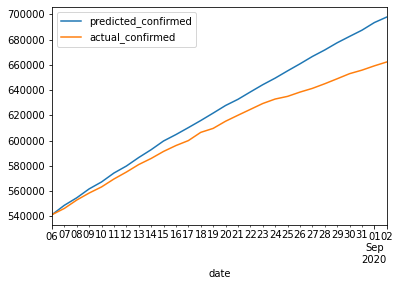

In [15]:
# plot trend chart

chart_data = pysqldf("""
select
    date,
    predicted_confirmed_delta_per_capita,
    future_confirmed_delta_per_capita actual_confirmed_delta_per_capita
from
    results
where
    state = '{state}' and
    shelter_in_place_policy = 1 and
    food_and_drink_policy = 1 and
    non_essential_businesses_policy = 1 and
    face_mask_public_policy = 1 and
    face_mask_business_policy = 1
order by
    date
""".format(state = state))

# accumlate to total confirmed

def accumulate_confirmed(initial_confirmed, population, confirmed_per_capital_series):
    out = [initial_confirmed]
    for i in range(0, len(confirmed_per_capital_series) - 1):
        out.append(out[i] + population * confirmed_per_capital_series[i])
    return out

population = pysqldf(
    "select population2019 from population2019_data where state = '{state}'".format(state = state)
)['population2019'][0]

initial_date = pysqldf("""
select min(date) from results where state = '{state}'
""".format(state = state))['min(date)'][0]

initial_confirmed = pysqldf("""
select confirmed from csse_data where state = '{state}' and date = '{date}'
""".format(state = state, date = initial_date))['confirmed'][0]

chart_data = pandas.DataFrame(
    {
        'predicted_confirmed': accumulate_confirmed(initial_confirmed, population, chart_data['predicted_confirmed_delta_per_capita'].to_numpy()),
        'actual_confirmed': accumulate_confirmed(initial_confirmed, population, chart_data['actual_confirmed_delta_per_capita'].to_numpy()),
    },
    index = pandas.to_datetime(chart_data['date'])
)

chart_data.plot()

In [23]:
# generate CSV

csv_data = None

for p1 in (0, 1):
    for p2 in (0, 1):
        for p3 in (0, 1):
            for p4 in (0, 1):
                for p5 in (0, 1):
                    csv_fragment = pysqldf("""
                    select
                        date,
                        state,
                        shelter_in_place_policy,
                        food_and_drink_policy,
                        non_essential_businesses_policy,
                        face_mask_public_policy,
                        face_mask_business_policy,
                        predicted_confirmed_delta_per_capita,
                        future_confirmed_delta_per_capita actual_confirmed_delta_per_capita
                    from
                        results
                    where
                        state = '{state}' and
                        shelter_in_place_policy = {p1} and
                        food_and_drink_policy = {p2} and
                        non_essential_businesses_policy = {p3} and
                        face_mask_public_policy = {p4} and
                        face_mask_business_policy = {p5}
                    order by
                        date
                    """.format(state = state, p1 = p1, p2 = p2, p3 = p3, p4 = p4, p5 = p5))
                    csv_fragment.insert(
                        9,
                        "predicted_confirmed",
                        accumulate_confirmed(initial_confirmed, population, csv_fragment['predicted_confirmed_delta_per_capita'].to_numpy())
                    )
                    csv_fragment.insert(
                        9,
                        "actual_confirmed",
                        accumulate_confirmed(initial_confirmed, population, csv_fragment['actual_confirmed_delta_per_capita'].to_numpy())
                    )
                    if csv_data is None:
                        csv_data = csv_fragment
                    else:
                        csv_data = pandas.concat([csv_data, csv_fragment])
                    
csv_data.to_csv("predicted_confirmed_policy_exploded.csv")
csv_data

,date,state,shelter_in_place_policy,food_and_drink_policy,non_essential_businesses_policy,face_mask_public_policy,face_mask_business_policy,predicted_confirmed_delta_per_capita,actual_confirmed_delta_per_capita,actual_confirmed,predicted_confirmed
0,2020-08-06,ca,0,0,0,0,0,0.000202,0.000126,541339.0,541339.000000
1,2020-08-07,ca,0,0,0,0,0,0.000150,0.000168,546332.0,549308.641561
2,2020-08-08,ca,0,0,0,0,0,0.000188,0.000140,552965.0,555225.474199
3,2020-08-09,ca,0,0,0,0,0,0.000132,0.000123,558500.0,562665.707512
4,2020-08-10,ca,0,0,0,0,0,0.000172,0.000159,563345.0,567883.849686
...,...,...,...,...,...,...,...,...,...,...,...
23,2020-08-29,ca,1,1,1,1,1,0.000127,0.000102,648970.0,677463.504200
24,2020-08-30,ca,1,1,1,1,1,0.000125,0.000071,652998.0,682493.421618
25,2020-08-31,ca,1,1,1,1,1,0.000153,0.000086,655793.0,687425.204644
26,2020-09-01,ca,1,1,1,1,1,0.000111,0.000078,659199.0,693470.323226
